In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA

from itertools import combinations
from collections import Counter

In [2]:
X_train = pd.read_csv('../data/phase1/train/X_train.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv('../data/phase1/test/X_test.txt', delim_whitespace=True, header=None)

In [3]:
feature_names = pd.read_csv('../data/phase1/features.txt', delim_whitespace=True, header=None)
feature_names['dup_number'] = feature_names.reset_index().groupby(0).rank()
feature_names['features'] = feature_names.apply(
    lambda x: x[0] + ('-dup-' + str(int(x['dup_number'])) if x['dup_number']>1 else '') , axis=1)

col_names = feature_names['features'].tolist()
X_train.columns = col_names
X_test.columns = col_names

In [4]:
X_train.head(4)

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.012236,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.202804,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,0.440079,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,0.430891,-0.138373,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826


In [5]:
y_train = pd.read_csv('../data/phase1/train/y_train.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('../data/phase1/test/y_test.txt', delim_whitespace=True, header=None)

## Map label names:

In [6]:
label_info = pd.read_csv('../data/phase1/activity_labels.txt', delim_whitespace=True, header=None, index_col=False)
label_mapping = dict()

for index, row_data in label_info.iterrows():
    label_mapping.update({row_data[0] : row_data[1]})
    
y_train = y_train.applymap(lambda int_value: label_mapping[int_value])
y_test = y_test.applymap(lambda int_value: label_mapping[int_value])

In [7]:
# y_train = y_train.applymap(lambda int_value: label_mapping[int_value])
# y_test = y_test.applymap(lambda int_value: label_mapping[int_value])

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7767, 561), (3162, 561), (7767, 1), (3162, 1))

## Dimensionality Reduction:

In [9]:
pca = PCA()
X_train_pc = pca.fit_transform(X_train)

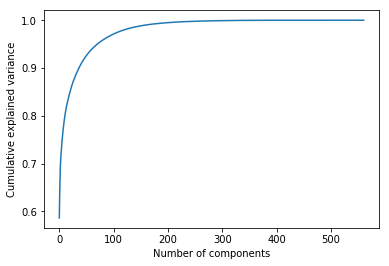

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

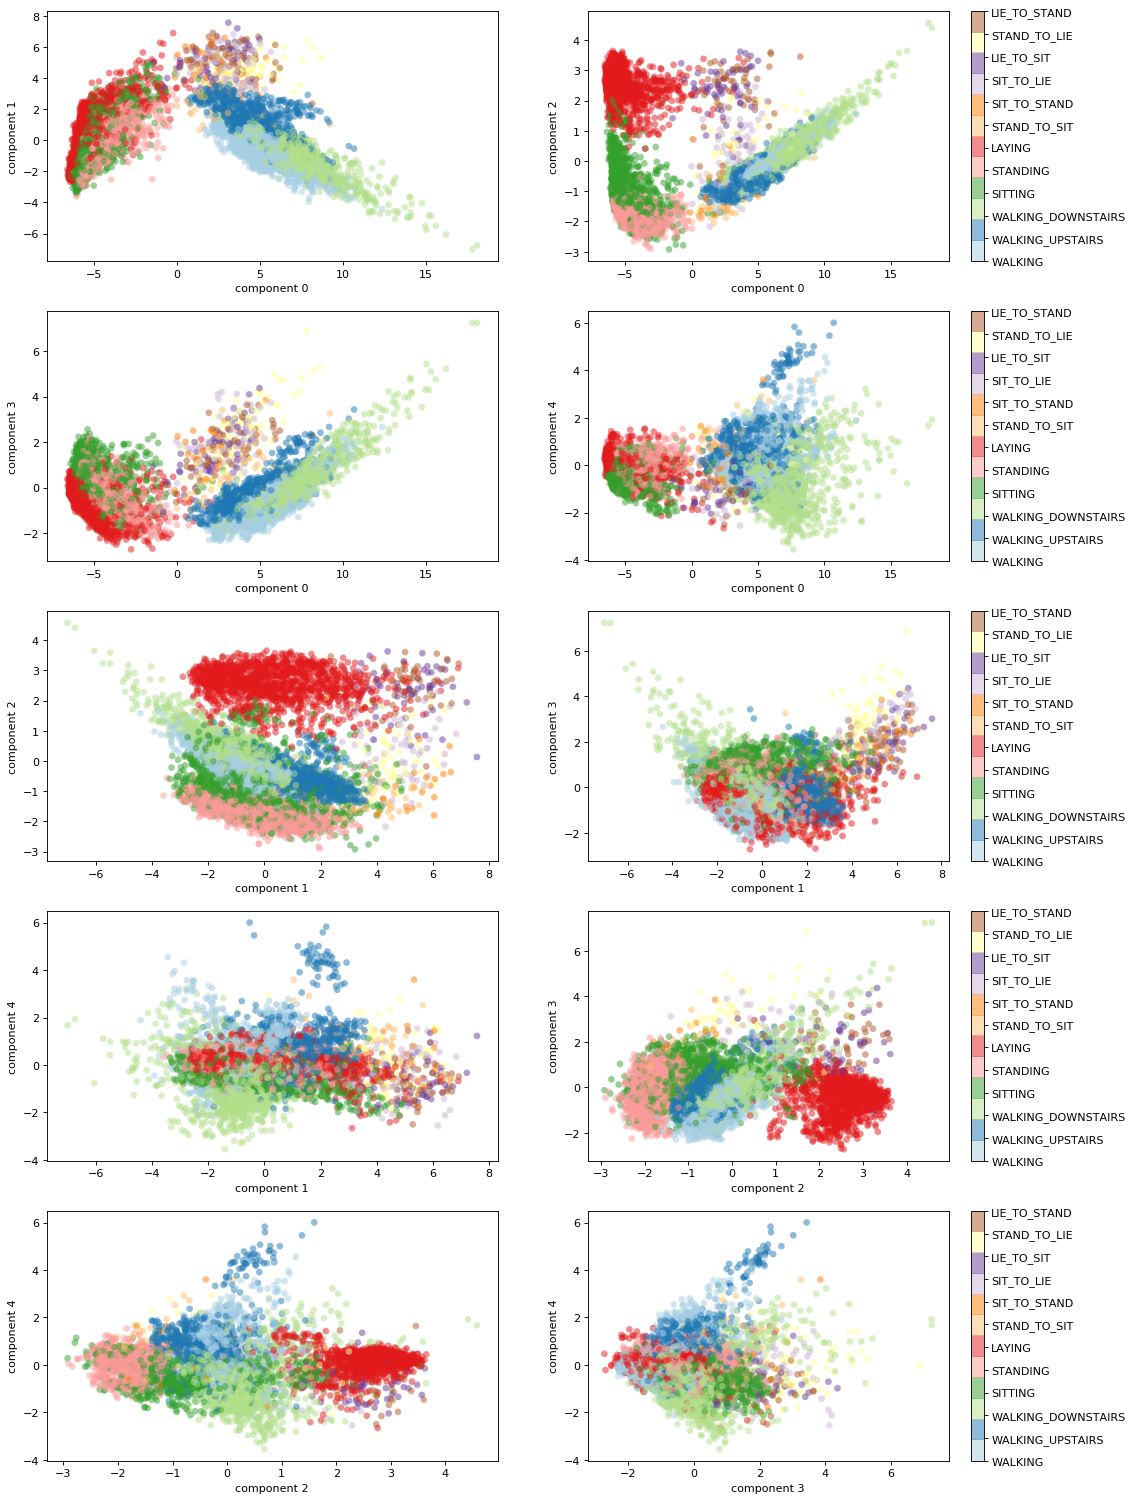

In [11]:
figure(num=None, figsize=(16, 24), dpi=80, facecolor='w', edgecolor='k')

def fmt(x, pos):
    return '{}'.format(label_mapping[x])

component_comb = list(combinations(range(5), 2))
n_cols = 2
n_rows = np.ceil(len(component_comb)/n_cols)

for i, comps in enumerate(component_comb):    
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(X_train_pc[:, comps[0]], X_train_pc[:, comps[1]],
                c=y_train[0], edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Paired', 12))
    plt.xlabel('component {}'.format(comps[0]))
    plt.ylabel('component {}'.format(comps[1]))
    if i%2 == 1:
        plt.colorbar(ticks=range(1, 13), format=ticker.FuncFormatter(fmt), orientation='vertical');


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
# from random import sample
# temp_X_train = X_train[sample(set(X_train.columns), 10)].copy()

In [14]:
def remove_multicollinearity(df):
    temp_df = df.copy()
    is_continued = True

    while(is_continued):
        vif = [(col_name, variance_inflation_factor(
            temp_df.values,
            temp_df.columns.get_loc(col_name))) for col_name in temp_df.columns
        ]
        max_vif = sorted(vif, key=lambda x: x[1], reverse=True)[0]
        if max_vif[1] > 5:
            print("dropping: {}".format(max_vif))
            temp_df.drop(max_vif[0], axis=1, inplace=True)
        else:
            print("stop: {}".format(max_vif))
            is_continued = False
    return temp_df

In [15]:
X_train_reduced_ = remove_multicollinearity(X_train)

/Users/rahul/.virtualenvs/gqp-takeda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping: ('tBodyAcc-Energy-1', inf)
dropping: ('tBodyAccJerk-Energy-1', inf)
dropping: ('tBodyGyro-Energy-1', inf)
dropping: ('tBodyGyroJerk-Energy-1', inf)
dropping: ('tBodyAccMag-Mean-1', inf)
dropping: ('tBodyAccMag-STD-1', inf)
dropping: ('tBodyAccMag-Mad-1', inf)
dropping: ('tBodyAccMag-Max-1', inf)
dropping: ('tBodyAccMag-Min-1', inf)
dropping: ('tBodyAccMag-SMA-1', inf)
dropping: ('tBodyAccMag-Energy-1', inf)
dropping: ('tBodyAccMag-IQR-1', inf)
dropping: ('tBodyAccMag-ropy-1', inf)
dropping: ('tBodyAccMag-ARCoeff-1', inf)
dropping: ('tBodyAccMag-ARCoeff-2', inf)
dropping: ('tBodyAccMag-ARCoeff-3', inf)
dropping: ('tBodyAccMag-ARCoeff-4', inf)
dropping: ('tGravityAccMag-Mean-1', inf)
dropping: ('tBodyAccJerkMag-Mean-1', inf)
dropping: ('tBodyGyroMag-Mean-1', inf)
dropping: ('tBodyGyroJerkMag-Mean-1', inf)
dropping: ('fBodyAcc-Mean-1', inf)
dropping: ('fBodyAcc-Energy-1', inf)
dropping: ('fBodyAcc-Energy-2', inf)
dropping: ('fBodyAcc-Energy-3', inf)
dropping: ('fBodyAcc-BandsEne

dropping: ('fBodyAcc-BandsEnergyOld-40', 5112.740122345211)
dropping: ('fBodyAccJerk-Mean-3', 4943.77137754609)
dropping: ('tGravityAccMag-ARCoeff-2', 4889.791418000917)
dropping: ('fBodyAccMag-STD-1', 4747.381460422294)
dropping: ('tBodyAccJerk-Mad-1', 4427.59089117804)
dropping: ('tBodyGyro-Mad-3', 4419.610203823289)
dropping: ('tGravityAcc-Mean-1', 4198.4975074138765)
dropping: ('fBodyGyro-BandsEnergyOld-40', 4094.4051980981053)
dropping: ('tBodyGyro-Mad-1', 4081.0682535080086)
dropping: ('fBodyAccJerkMag-STD-1', 4065.805954523267)
dropping: ('tBodyAcc-Mad-2', 3999.4276979552083)
dropping: ('fBodyGyro-Mad-2', 3977.935829201903)
dropping: ('tBodyGyroMag-SMA-1', 3704.0264067687367)
dropping: ('fBodyAcc-BandsEnergyOld-42', 3658.3429310722036)
dropping: ('fBodyGyroJerkMag-SMA-1', 3543.376806947704)
dropping: ('fBodyGyro-BandsEnergyOld-25', 3482.6575805271405)
dropping: ('fBodyAcc-BandsEnergyOld-22', 3477.74046287121)
dropping: ('fBodyAcc-Mean-3', 3365.4180624394653)
dropping: ('fBodyAcc

dropping: ('fBodyAccJerk-ropy-1-dup-3', 216.2021572601626)
dropping: ('fBodyAcc-Kurtosis-1-dup-3', 210.90453991335036)
dropping: ('fBodyAcc-Max-1', 209.0425535391251)
dropping: ('fBodyAccJerk-Max-2', 204.68994480042372)
dropping: ('tBodyGyroJerkMag-ropy-1', 203.66609636173627)
dropping: ('fBodyAccJerk-ropy-1-dup-2', 197.06106568197566)
dropping: ('tBodyGyro-Max-1', 193.77259526388423)
dropping: ('fBodyAcc-IQR-3', 191.29102476224014)
dropping: ('tBodyGyroJerk-Max-2', 191.1603706440007)
dropping: ('fBodyAccMag-Kurtosis-1', 190.08344806711762)
dropping: ('tBodyGyroJerk-Min-3', 189.58566883107204)
dropping: ('fBodyAccJerk-BandsEnergyOld-6', 189.00351700213446)
dropping: ('tBodyGyroJerk-Max-1', 186.25874167359777)
dropping: ('tZAxisAcc-AngleWRTGravity-1', 184.94781823918342)
dropping: ('fBodyAccJerk-BandsEnergyOld-36', 184.21792347070385)
dropping: ('tBodyGyro-ARCoeff-5', 182.40041748650106)
dropping: ('tBodyGyroJerk-IQR-1', 179.83656740476056)
dropping: ('fBodyAcc-BandsEnergyOld-8', 178.66

dropping: ('fBodyAccJerk-MeanFreq-2', 7.399992464881336)
dropping: ('fBodyAccJerkMag-MeanFreq-1', 7.2485956439651105)
dropping: ('tBodyAcc-ropy-1-dup-3', 7.202098247916152)
dropping: ('fBodyAccJerk-MeanFreq-1', 7.107855118235173)
dropping: ('tGravityAcc-ropy-1-dup-3', 6.870224197929368)
dropping: ('tGravityAccMag-ARCoeff-3', 6.62363258025231)
dropping: ('fBodyGyroMag-MeanFreq-1', 6.520007656571654)
dropping: ('tGravityAcc-ARCoeff-5', 5.909060254729393)
dropping: ('tBodyGyroJerk-ARCoeff-1', 5.587255446999613)
dropping: ('fBodyAccJerk-MaxInds-1', 5.267899469057589)
stop: ('fBodyAccJerk-MaxInds-2', 4.967073484588068)


In [20]:
vif_selected_columns = X_train_reduced_.columns.to_list()

In [22]:
import pickle

In [35]:
with open('vif_selected_columns.pickle', 'rb') as p_file:
    check = pickle.load(p_file)

In [41]:
vif = [(col_name, variance_inflation_factor(
            X_train_reduced_.values,
            X_train_reduced_.columns.get_loc(col_name))) for col_name in X_train_reduced_.columns
        ]

In [44]:
len(vif)

86

In [ ]:
all_data = X_train.copy()
all_data['label'] = y_train

In [ ]:
all_data.columns

In [39]:
X_train_reduced_.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-ARCoeff-4,tBodyAcc-ARCoeff-8,tBodyAcc-ARCoeff-12,tBodyAcc-Correlation-1,tBodyAcc-Correlation-2,tBodyAcc-Correlation-3,tGravityAcc-Min-2,...,fBodyGyro-Skewness-1-dup-3,fBodyAccMag-Skewness-1,fBodyAccJerkMag-Skewness-1,fBodyGyroMag-Skewness-1,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1
0,0.043580,-0.005970,-0.035054,-0.161318,-0.020958,-0.206337,0.376778,0.435172,0.660199,-0.121513,...,-0.496486,-0.446120,-0.517127,0.565697,-0.012236,-0.314848,-0.112754,0.030400,-0.464761,-0.018446
1,0.039480,-0.002131,-0.029067,0.200417,-0.192986,-0.236609,-0.012696,-0.072711,0.578649,-0.113205,...,-0.161767,-0.128777,-0.625993,-0.364219,0.202804,-0.603199,0.053477,-0.007435,-0.732626,0.703511
2,0.039978,-0.005153,-0.022651,-0.273292,-0.240491,-0.316816,-0.123889,-0.181137,0.608219,-0.113205,...,-0.402077,-0.630062,-0.725887,-0.564868,0.440079,-0.404427,-0.118559,0.177899,0.100699,0.808529
3,0.039785,-0.011809,-0.028916,-0.378262,-0.090862,-0.490389,-0.304759,-0.362708,0.506602,-0.119638,...,-0.389158,-0.478367,-0.702305,-0.257142,0.430891,-0.138373,-0.036788,-0.012892,0.640011,-0.485366
4,0.038758,-0.002289,-0.023863,-0.007998,-0.224589,-0.102650,-0.154974,-0.189796,0.598515,-0.120135,...,-0.275324,-0.119313,-0.529957,-0.539596,0.137735,-0.366214,0.123320,0.122542,0.693578,-0.615971
